# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       # transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [5]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [32]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [33]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # Validate the 
    test(model, device, test_loader)

  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.09939953684806824 Batch_id=468 Accuracy=89.06: 100%|██████████████████████████| 469/469 [00:10<00:00, 45.94it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0941, Accuracy: 9718/10000 (97.18%)

EPOCH: 1


Loss=0.03135983273386955 Batch_id=468 Accuracy=97.83: 100%|██████████████████████████| 469/469 [00:10<00:00, 46.40it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0550, Accuracy: 9853/10000 (98.53%)

EPOCH: 2


Loss=0.03149324283003807 Batch_id=468 Accuracy=98.40: 100%|██████████████████████████| 469/469 [00:10<00:00, 46.70it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9906/10000 (99.06%)

EPOCH: 3


Loss=0.023784959688782692 Batch_id=468 Accuracy=98.66: 100%|█████████████████████████| 469/469 [00:10<00:00, 46.35it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9897/10000 (98.97%)

EPOCH: 4


Loss=0.009934898465871811 Batch_id=468 Accuracy=98.75: 100%|█████████████████████████| 469/469 [00:09<00:00, 46.91it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9909/10000 (99.09%)

EPOCH: 5


Loss=0.05259503424167633 Batch_id=468 Accuracy=98.88: 100%|██████████████████████████| 469/469 [00:10<00:00, 46.34it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9919/10000 (99.19%)

EPOCH: 6


Loss=0.022051066160202026 Batch_id=468 Accuracy=98.92: 100%|█████████████████████████| 469/469 [00:10<00:00, 46.56it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9918/10000 (99.18%)

EPOCH: 7


Loss=0.03308583423495293 Batch_id=468 Accuracy=98.97: 100%|██████████████████████████| 469/469 [00:10<00:00, 45.99it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9933/10000 (99.33%)

EPOCH: 8


Loss=0.04667101800441742 Batch_id=468 Accuracy=99.04: 100%|██████████████████████████| 469/469 [00:10<00:00, 46.03it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9933/10000 (99.33%)

EPOCH: 9


Loss=0.007109272759407759 Batch_id=468 Accuracy=99.11: 100%|█████████████████████████| 469/469 [00:10<00:00, 46.18it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9929/10000 (99.29%)

EPOCH: 10


Loss=0.022630514577031136 Batch_id=468 Accuracy=99.08: 100%|█████████████████████████| 469/469 [00:10<00:00, 45.14it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9938/10000 (99.38%)

EPOCH: 11


Loss=0.011735159903764725 Batch_id=468 Accuracy=99.08: 100%|█████████████████████████| 469/469 [00:10<00:00, 45.02it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9924/10000 (99.24%)

EPOCH: 12


Loss=0.08325657993555069 Batch_id=468 Accuracy=99.17: 100%|██████████████████████████| 469/469 [00:10<00:00, 45.23it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9928/10000 (99.28%)

EPOCH: 13


Loss=0.00563923129811883 Batch_id=468 Accuracy=99.16: 100%|██████████████████████████| 469/469 [00:10<00:00, 45.30it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9933/10000 (99.33%)

EPOCH: 14


Loss=0.0034329656045883894 Batch_id=468 Accuracy=99.19: 100%|████████████████████████| 469/469 [00:10<00:00, 46.56it/s]



Test set: Average loss: 0.0213, Accuracy: 9924/10000 (99.24%)



Text(0.5, 1.0, 'Test Accuracy')

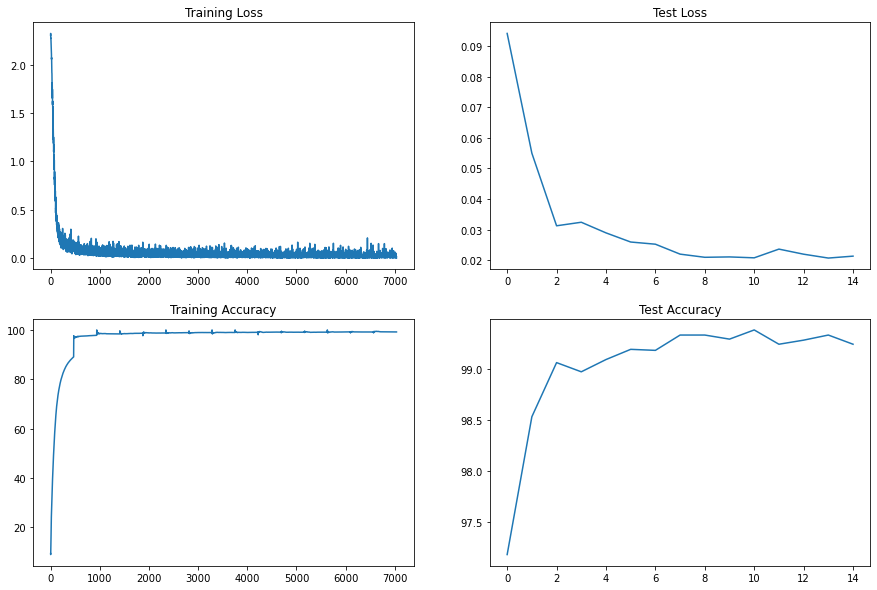

In [35]:
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Observations
### Target
1. Get the Setup Right
2. Get a Good Accuracy not to worry on the <=10K parameters now.
3. Make sure the data loaders are working
4. Setup the basic training/testing pipeline
5. Create a Baseline Model
6. Use 15 Epochs

### Result 
1. Parameters : 13,808
2. Good Train and Test Accuracy : 99.19% and 99.38%

### Analysis
1. Model is not Overfitting, need to reduce the number of parameters<=10k.
2. Add more Transformation /Data Augmentation

### Model Used


In_channels Output_channels Kernel_Size

## 1. Convolution Block 1
Conv2D:  1, 16, 3  Output: 26x26x16

Conv2D: 16, 32, 3  Output: 24x24x32

## 2. Transition Block(Covolution+Max Pool)
Conv2D: 32, 10, 1 Output: 24x24x10 

MaxPool2D: 2x2    Output: 12x12x10

## 3. Convolution Block 2
Conv2D: 10, 16, 3 Output: 10x10x16

Conv2D: 16, 16, 3 Output: 8x8x16

Conv2D: 16, 16, 3 Output: 6x6x16

Conv2D: 16, 16, 3 Output: 6x6x16; Padding=1

## 4. Global Average Pooling
AvgPool2D: 6x6     Output: 1x1x16

Conv2D: 16, 10, 1  Output: 1x1x10
